/Users/lucastian/miniconda3/envs/babyglot/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'helmholtz.WSR' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/lucastian/miniconda3/envs/babyglot/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'examples.mnist.mnist.NADE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/lucastian/miniconda3/envs/babyglot/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'examples.mnist.mnist.PxIID' has changed. you can retrieve the original so

Loaded model.p


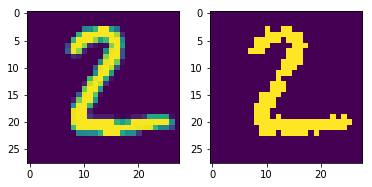

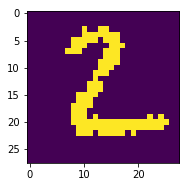

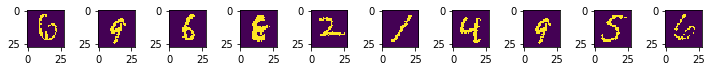

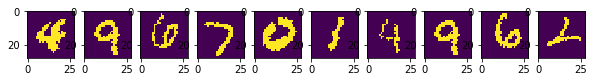

In [2]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import examples.mnist as M
import numpy as np

model=torch.load("./model.p", map_location='cpu') #LT
print("Loaded model.p")



## ==== REPLACE M.testdata WITH TORCHVISION MNIST DATA, so that have accurate labels.
# scale by 255, sample from bernoulli with those p, in order to binarize.


import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

mnist_test = datasets.MNIST(root='./data', train=False, download=True)
mnist_test.test_data = mnist_test.test_data.reshape(-1, 1, 28, 28)

# ===== BINARIZES THE DATASET
from torch.distributions.bernoulli import Bernoulli
mnist_bin = Bernoulli(mnist_test.test_data.to(torch.float64)/255).sample()

plt.figure()
plt.subplot(121)
plt.imshow(mnist_test.test_data.to(torch.float64)[1][0])
plt.subplot(122)
plt.imshow(mnist_bin[1][0])

mnist_test.test_data = mnist_bin

mnist_test.test_data.to(torch.uint8)
mnist_test.test_data[0][0]

plt.figure()
plt.subplot(121)
plt.imshow(mnist_test.test_data[1][0])

# ========= PERFORM REPLACEMENT
n = M.testdata.shape[0]
M.testdata = mnist_test.test_data[0:n]
M.testlabels = mnist_test.test_labels[0:n]


## ===== COMPARE original binarized dataset (above, train) vs. one that I made (below, test)

plt.figure(figsize=(10,20))
indthis = np.random.randint(low=0, high=100, size=10)
for i, ind in enumerate(indthis):
    plt.subplot(1,10,i+1)
    plt.imshow(M.data[ind][0].numpy().reshape(28, 28), vmin=0, vmax=1)
    plt.tight_layout()
    
plt.figure(figsize=(10,20))
for i, ind in enumerate(indthis):
    plt.subplot(1,10,i+1)
    plt.imshow(M.testdata[ind][0].numpy().reshape(28, 28), vmin=0, vmax=1)
##    plt.tight_layout()

# Classification code below

## define a function that loads appropriate characters

def getIdx(charSamp, M, Nway=20):    
#     charSamp = 1 # the sample integer (0,...,9)
#     Nway = 20 # how many test characters (only 1 will match the Samp)

    charSamp = torch.tensor(np.array(charSamp))
    
    # get sample
    a = np.where(M.testlabels==charSamp)
    idx_sample, idx_testmatch = np.random.choice(a[0], size=2, replace=False)

    # get the N-1 test that do not match the sample
    a = np.where(M.testlabels!=charSamp)
    idx_testnonmatch = np.random.choice(a[0], size=Nway-1, replace=False)
    
    return idx_sample, idx_testmatch, idx_testnonmatch


idx_sample, idx_testmatch, idx_testnonmatch = getIdx(1, M)




In [3]:
import pickle


def plotResult(w, f, u, n=None, nlev=None, t=None, RedoUpdate=True, plotSimple=False):
    # n=10 (for 10 noise renditions)
    # t = 'Test' or 'Train'
    
    if n is not None:
        nn = 'n%s' %(n)
    else:
        nn = ''
        
    if nlev is None:
        nlev = ''
    else:
        nlev = 'nlev%s' %(nlev)
        
    if t is None:
        t = ''
        
    fname = './datsave/datall_w%sf%su%s' %(w, f, u) + nn +nlev + t
    
    if not RedoUpdate:
        fname = fname + 'noRedoUpdate'
        
    print(fname)
    
    with open(fname, 'rb') as f:
        scores_all, scores_sampmodel, scores_sampmodel_all, idx_all \
        = pickle.load(f)



    if plotSimple is False:
        ## SUMMARIZE CLASSIFICATION ERROR
        # ===== 1) PLOT likelihood probabilites
        plt.figure(figsize=(18, 5))

        for nn in range(10):

            plt.subplot(2,5,nn+1)
            plt.title('int=%d' % nn)

        #     scorestoplot = [scores_all[ii] for ii in range(len(idx_all)) if M.testlabels[idx_all[ii][0]]==nn] # trials with nn as trainsamp
        #     plt.plot(scorestoplot, '-ok')

            trialsthis = [ii for ii in range(len(idx_all)) if M.testlabels[idx_all[ii][0]]==nn] # trials with nn as trainsamp

            for tt in trialsthis:
                plt.plot(scores_all[tt].detach().numpy(), '-')




        # ===== PLOT - combine across integers
        plt.figure(figsize=(10, 5))
        for ss in scores_all:
            plt.plot(ss.detach().numpy(), '-')
        plt.xlabel('train-test-rest')
        plt.ylabel('log(posterior predictive prob)')
        
    
    # ==== Histogram of "rank" for the correct test
    tmp = [sum(scores_all[i][1]>scores_all[i][2:]) for i in range(len(scores_all))]
    rank = np.array(len(scores_all[0])-2)-tmp # ranges from 0 to NumOthers

    plt.figure()

    plt.subplot(1,2,1)
    plt.hist(rank, density=True)
    plt.title('rank of actual match (using sum of bidir probabilites)')
    plt.xlabel('rank(0==>best match)')

    plt.subplot(1,2,2)
    plt.hist(rank, density=False)
    
    


./datsave/datall_w20f10u100


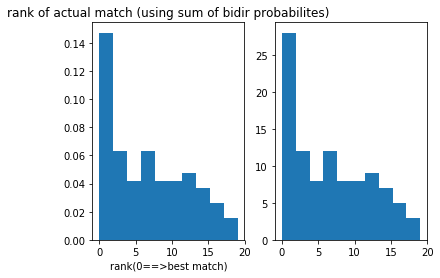

In [4]:
plotResult(w=20, f=10, u=100, plotSimple=True)


In [5]:
plotResult(w=20, f=1, u=20, plotSimple=True)
plotResult(w=20, f=5, u=20, plotSimple=True)
plotResult(w=20, f=10, u=20, plotSimple=True)
plotResult(w=20, f=10, u=100, plotSimple=True)


./datsave/datall_w20f1u20


FileNotFoundError: [Errno 2] No such file or directory: './datsave/datall_w20f1u20'

In [6]:
plotResult(w=20, f=1, u=20, plotSimple=True)
plotResult(w=20, f=5, u=20, plotSimple=True)
plotResult(w=20, f=10, u=20, plotSimple=True)
plotResult(w=20, f=10, u=100, plotSimple=True)


./datsave/datall_w20f1u20


FileNotFoundError: [Errno 2] No such file or directory: './datsave/datall_w20f1u20'

./datsave/datall_w10f10u20


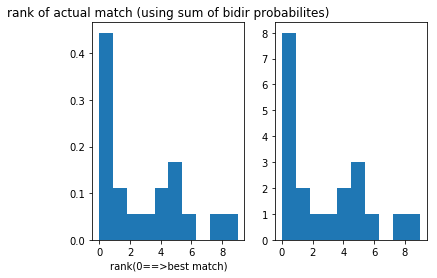

In [7]:
plotResult(w=10, f=10, u=20, plotSimple=True)

./datsave/datall_w20f10u100Train
./datsave/datall_w20f10u100n10Train
./datsave/datall_w20f10u100Test
./datsave/datall_w20f10u100n10nlev0.2Test
./datsave/datall_w20f10u100n10Test


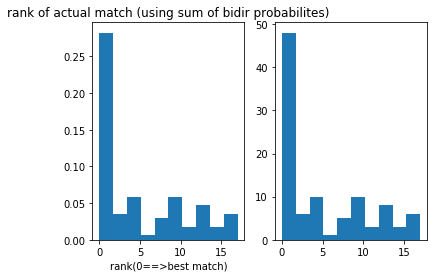

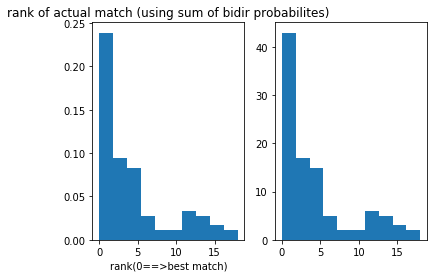

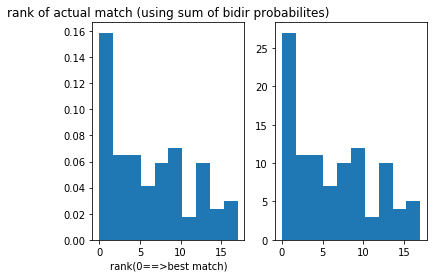

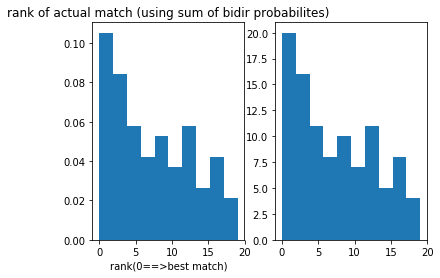

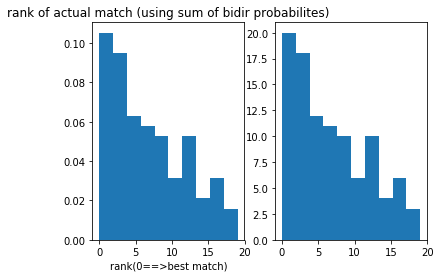

In [8]:
plotResult(w=20, f=10, u=100, n=None, t='Train', plotSimple=True) # no noise
# plotResult(w=20, f=10, u=100, n=10, nlev=0.2, t='Train', plotSimple=True) # noise = 0.2 IGNORE SINCE OVERWROTE (not sure what it is)
plotResult(w=20, f=10, u=100, n=10, t='Train', plotSimple=True) # noise = 0.4

plotResult(w=20, f=10, u=100, n=None, t='Test', plotSimple=True)
plotResult(w=20, f=10, u=100, n=10, nlev=0.2, t='Test', plotSimple=True) # noise = 0.2
plotResult(w=20, f=10, u=100, n=10, t='Test', plotSimple=True)

./datsave/datall_w20f10u100n10nlev0.2TrainnoRedoUpdate


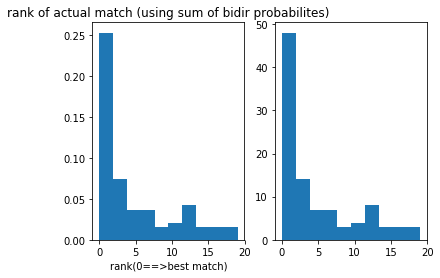

In [9]:
plotResult(w=20, f=10, u=100, n=10, nlev=0.2, t='Train', RedoUpdate=False, plotSimple=True)